# 内容
- meeting_0407.ipynbファイルのエネルギー定義別バージョン（相関係数を利用する）

# 案-1
- E =  -(選択した特徴量のうちの１つ　と　元の選択された特徴量のうちの１つ　での相関係数)の総和

## 相関係数とは
- 二つの値の間に関係性、つまり「ある値が高く(低く)なれば、もう一つの値も高く(低く)なる」と言う関係を数値化したもの
- pythonで使用可能なツール
 - ```numpy.corrcoef```
 - ```corr```

In [1]:
#例

import numpy

japanese = [5, 73, 29, 63, 68, 28, 45, 78, 70, 93]
math = [11, 82, 25, 61, 66, 27, 42, 88, 71, 84]

correlation = numpy.corrcoef(japanese, math)

print(correlation[0,1])

0.975751057911441


In [2]:
#例

import pandas as pd
import numpy as np

# テスト用のリストを作る
l1=list(np.random.randint(0, 10, 10))
l2=list(np.random.randint(0, 10, 10))

# 作ったlist
print(l1) #[4, 6, 0, 8, 6, 2, 0, 3, 3, 5]
print(l2) #[4, 6, 3, 7, 8, 4, 6, 9, 0, 0]

# リストをps.Seriesに変換
s1=pd.Series(l1)
s2=pd.Series(l2)

# pandasを使用してPearson's rを計算
res=s1.corr(s2)   # numpy.float64 に格納される

# 結果
print(res)

[4, 0, 5, 8, 2, 9, 9, 0, 5, 3]
[1, 5, 1, 7, 0, 4, 0, 8, 9, 0]
-0.10615321803015403


In [3]:
#import
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import random, math, warnings
from sklearn.feature_selection import SelectKBest, f_regression
#from sklearn.feature_selection import SelectKBest, chi2
import pprint
import itertools

In [31]:
#valiable
num_select = 3

every_MCS = 100

#降順である{1/b}の作成
Max_temper = 2000 #最高温度（スタート地点）
b = [100/j for j in reversed(range(1, Max_temper+1))]
print("1/bのトップバッター(最大値希望)1/b[0]は{}である".format(1/b[0]))
print("1/bのラスト1/b[-1]（最小値希望）は{}である".format(1/b[-1]))

1/bのトップバッター(最大値希望)1/b[0]は2.0である
1/bのラスト1/b[-1]（最小値希望）は0.001である


In [5]:
X = pd.read_table('geneX_df.txt',sep ='\t')# 説明変数（こっちの特徴量上位5つ取り出す）
print("X.shape is {}".format(X.shape))

y = pd.read_table('ERY_df.txt' ,sep ='\t')# 目的変数
#print('type of y is {}'.format(type(y)))

num_sample = X.shape[0]#サンプル数
num_feature = X.shape[1]#特徴量の数

#Kをはじめにlist upするyの数とする

X.shape is (781, 16799)


サンプルが

In [6]:
#falseしかない！！
#X.isnull().apply(lambda col: col.value_counts(), axis=0).fillna(0).astype(np.int)

In [7]:
X.head()

,ARHGEF10L,HIF3A,RNF17,RNF11,REM1,RTN4RL2,C16orf13,C16orf11,FGFR1OP2,TSKS,...,TULP2,NPY5R,GNGT2,GNGT1,TULP3,PTRF,BCL6B,GSTK1,SELP,SELS
TCGA-A8-A092-01,-0.92667,-4.836158,-0.545559,-0.425362,-2.511796,1.420118,-0.076931,-0.583953,-0.064954,-1.262546,...,-0.727478,-1.319172,-0.534283,-0.871063,0.137041,-0.494064,-0.396097,-1.178462,-1.748619,-0.659749
TCGA-D8-A1JK-01,-0.83967,-3.260158,0.420041,0.718538,-0.322796,-1.267982,0.252869,-0.583953,-0.031154,-1.634746,...,-0.165278,-1.691372,0.783017,0.037337,-0.051459,0.730136,1.388803,1.339138,-1.924519,0.075451
TCGA-E2-A10C-01,-0.11937,-4.646958,-0.545559,-0.453962,-1.073796,-1.506382,1.084969,1.680847,0.010146,0.890654,...,-0.166078,-1.129972,-0.350883,-0.681864,-0.206159,-0.406364,0.354103,-0.003162,-0.903719,-0.195349
TCGA-BH-A0C7-01,0.28803,-1.599358,-0.545559,-0.211162,-2.041396,-0.156182,-0.861231,-0.583953,-0.249454,-1.029746,...,-0.122478,-0.488172,-0.616583,-1.243263,0.330741,-0.188764,0.420403,-0.456262,0.914881,-0.427849
TCGA-A8-A06N-01,0.61053,-4.268858,-0.545559,0.764638,-2.182996,-1.431682,-0.876131,-0.583953,0.560146,-1.634746,...,-0.429378,2.566228,-1.073483,-1.243263,0.133141,-2.727864,-0.306397,-0.882762,-3.308419,-0.224949


In [8]:
#type(X.iloc[3, 5]) #numpy.float64

In [9]:
y.head()

,ER_Status_nature2012
TCGA-A8-A092-01,Positive
TCGA-D8-A1JK-01,Negative
TCGA-E2-A10C-01,Positive
TCGA-BH-A0C7-01,Positive
TCGA-A8-A06N-01,Positive


In [10]:
len(y)

781

In [11]:
# 1 行目の 1 列目の値を取得
#df.iloc[1,1]

for i in range(len(y)):
    if y.iloc[i, 0]=="Positive":
        y.iloc[i, 0]=np.float(1)
    else:
        y.iloc[i, 0]=np.float(0)

In [12]:
y.head()

,ER_Status_nature2012
TCGA-A8-A092-01,1
TCGA-D8-A1JK-01,0
TCGA-E2-A10C-01,1
TCGA-BH-A0C7-01,1
TCGA-A8-A06N-01,1


In [13]:
type(y)

pandas.core.frame.DataFrame

In [14]:
print(X.shape)
print(y.shape)

(781, 16799)
(781, 1)


In [15]:
series_y = y.loc[:, 'ER_Status_nature2012']
series_y

TCGA-A8-A092-01    1
TCGA-D8-A1JK-01    0
TCGA-E2-A10C-01    1
TCGA-BH-A0C7-01    1
TCGA-A8-A06N-01    1
                  ..
TCGA-EW-A1OX-01    1
TCGA-BH-A0BJ-01    1
TCGA-EW-A1IY-01    1
TCGA-D8-A142-01    0
TCGA-BH-A1FC-01    0
Name: ER_Status_nature2012, Length: 781, dtype: int64

In [16]:
type(series_y)

pandas.core.series.Series

In [17]:
num_sample = X.shape[0]#サンプル数
num_feature = X.shape[1]#特徴量の数

👇```dead```してしまう

原因はおそらく**メモリのオーバーフロー**
- 私のpcメモリ...16 GB 2133 MHz LPDDR3
- 「Jupyter Notebookは、変数以外にもキャッシュしているものがあります。出力(Out)は間違いなくキャッシュしています。変数を出力した場合、その変数をキャシュしていると思われ、サイズの大きなものを出力した場合はそれがキャッシュに残ってしまうので、メモリ不足になりやすいと思われます。」



メモリー使用量を知る方法```memory_profiler```

```
pip install memory_profiler
%load_ext memory_profiler
import numpy as np
import gc

a = np.random.rand(10000,10000)
%memit
del a
gc.collect()
%memit
```

<br/>
対処法

- Jupyter Notebookを使わずにPythonファイルにして実行する(Jupyter Notebookのオーバーヘッドを回避する) ←それでも解決されなかった


In [18]:
'''
#状態y(yの色んなパターン)を作る
y_element = range(2) #0, 1なので
y_tuple_list = list(itertools.product(y_element, repeat=num_sample))

print("type of y_tuple_list's element is {}".format(type(y_tuple_list[0])))
print(type(pd.Series(y_tuple_list[0]))) #ori_yとtypeを揃えるためこのようにしてseriesにしないといけない
print("there are {} items in y_tuple_list.".format(len(y_tuple_list)))
'''


#はじめに用意するレプリカはK個(今回はlen(y_tuple_list)/Max_temperとしてみる。)
#すなわちもし一回もかぶらなかったら全通り制覇できる
#K = len(y_tuple_list)/Max_temper #419.4304
K = 2*210

```chi2```にしたら```non-negative```とエラーが出た➡```f_regression```にした

けど```f_regression```として良いのだろうか

よく出るエラー

```.py
ValueError: Found input variables with inconsistent numbers of samples: [3, 781]

ValueError                                Traceback (most recent call last)
<ipython-input-19-a320e6663903> in <module>
      4 #selector = SelectKBest(score_func=chi2, k=num_select)
      5 selector = SelectKBest(score_func=f_regression, k=num_select)
----> 6 selector.fit(X, series_y)
```

In [19]:
#mask_oriの計算（以降のエネルギー計算の基準となる）
#ori_y == yとなる場合だけ、E(y)==0となる仕様

#selector = SelectKBest(score_func=chi2, k=num_select) 
selector = SelectKBest(score_func=f_regression, k=num_select)
selector.fit(X, series_y)
mask_ori = selector.get_support()#各特徴量を選択したか否かのmaskを取得
mask_ori_columnums = [i for i in range(len(mask_ori)) if mask_ori[i]==True]

In [20]:
series_y

TCGA-A8-A092-01    1
TCGA-D8-A1JK-01    0
TCGA-E2-A10C-01    1
TCGA-BH-A0C7-01    1
TCGA-A8-A06N-01    1
                  ..
TCGA-EW-A1OX-01    1
TCGA-BH-A0BJ-01    1
TCGA-EW-A1IY-01    1
TCGA-D8-A142-01    0
TCGA-BH-A1FC-01    0
Name: ER_Status_nature2012, Length: 781, dtype: int64

In [21]:
mask_ori

array([False, False, False, ..., False, False, False])

In [22]:
#エネルギーが0(最低)となるのがいつか基準を先に計算しておきましょう

def E(y): #毎回のmaskとyが引数、合致度合いの計算を行う
    #selector = SelectKBest(score_func=chi2, k=num_select) #SelectKBest #chi2...分類
    selector = SelectKBest(score_func=f_regression, k=num_select) 
    selector.fit(X, y)
    mask_each = selector.get_support() #各特徴量を選択したか否かのmaskを取得
    
    #今回のyが選んだ特徴量のcolumn numberのリストを作る。
    mask_each_columnums = [i for i in range(len(mask_each)) if mask_each[i]==True]
    
    C_sum = sum([X.iloc[:, mask_ori_columnums[j]].corr(X.iloc[:, mask_each_columnums[j]]) for j in range(num_select)])
    
    '''
    C_sum = 0
    for j in range(num_select):
        C_each = X.iloc[:, ori_columns_list[j]].corr(X.iloc[:, mask_each_columnums[j]])
        C_sum += C_each
    '''
        
    return -C_sum #-(相関係数の合計値)

In [23]:
E(series_y)

-3.0

In [24]:
series_y

TCGA-A8-A092-01    1
TCGA-D8-A1JK-01    0
TCGA-E2-A10C-01    1
TCGA-BH-A0C7-01    1
TCGA-A8-A06N-01    1
                  ..
TCGA-EW-A1OX-01    1
TCGA-BH-A0BJ-01    1
TCGA-EW-A1IY-01    1
TCGA-D8-A142-01    0
TCGA-BH-A1FC-01    0
Name: ER_Status_nature2012, Length: 781, dtype: int64

👇ここで毎回```The kernel appears to have died. It will restart automatically.```
- num_sample = 10 できた
- num_sample = 100　もうだめ
- num_sample = 50　これでもだめ

### 今日教わったこと、わかったこと
```itertools.product```禁止

- そもそもモンテカルロはエネルギー差を見るもの。１つだけ変えるからエネルギー差がわかる

tried👇but didn't succeed

頻繁に起こるエラー
```'int' object is not subscriptable```。箇所は```ori_yj = y[j]```。```y```は```int```ではないのになぜ。

In [25]:
series_y #一行前までseriesなのになぜか数字になる時がある。

TCGA-A8-A092-01    1
TCGA-D8-A1JK-01    0
TCGA-E2-A10C-01    1
TCGA-BH-A0C7-01    1
TCGA-A8-A06N-01    1
                  ..
TCGA-EW-A1OX-01    1
TCGA-BH-A0BJ-01    1
TCGA-EW-A1IY-01    1
TCGA-D8-A142-01    0
TCGA-BH-A1FC-01    0
Name: ER_Status_nature2012, Length: 781, dtype: int64

In [26]:
bb = 3
j = random.randrange(bb)
ori_yj = series_y[j]

In [27]:
Ene = [] #これからi(温度)ごとに入れていく。一行に入っているのもlistにしたい(行i, 列k, 要素Ene)
y_list = [] #これからi(温度)ごとに、選択したyを記録していく。(行i, 要素num_tl)
high_P_Klist = []  #Wが大きい（Eneが小さい）の方々のメンバー(上位メンバー)所属(k)が入ったlist

for i in range(Max_temper):
    #print(type(series_y))
    Ene.append({})
    y_list.append([])
    for k in range(K):
        #print(type(series_y))
        j = random.randrange(num_sample)
        #print(type(series_y))
        ori_yj = series_y[j]
        series_y[j] = 1-series_y[j]
        Ene[-1][k]= E(pd.Series(series_y))
        y_list[-1].append(series_y)
        
        r = math.exp(-Ene[i][k]*b[i]-(-Ene[i-1][k]*b[i-1])) #Ene[i-1][k]*b[i-1] - Ene[i][k]*b[i] #大きいほうが良い
        #rr = math.exp(-eene[0][0]*b[3]-(-eene[1][0]*b[2])) 
        R = np.random.uniform(0.0, 1.0)
        if R > r : #乱数R > エネルギー差の大きさを用いた計算
            Ene[-1][k] = Ene[i-1][k]
            y_list[-1][k] = y_list[i-1][k]
            series_y = y_list[i-1][k]
    
    if i%every_MCS == 0:
        #Eneのi行目に数値が全部入ったら
        Ei_sorted = sorted(Ene[-1].items(), key=lambda x:x[1]) #Eの低い順にしたい
        tuple_kE_list = Ei_sorted[0:int(len(Ei_sorted)/2)] #上位の方々のメンバー情報が入ったtuple(k, Ene)が出来上がる

        #上位の方々のメンバー所属(k)が入ったlistを作る
        '''
        high_P_Klist.append([])
        for k in range(len(tuple_kE_list)):
            high_P_Klist[-1].append(tuple_kE_list[k][0])
        '''           
        high_P_Klist = [tuple_kE_list[k][0] for k in range(len(tuple_kE_list))]
        #print(high_P_Klist)

        #下位メンバーは上位メンバーに変えてしまう
        for k in range(int(K/2)):
            if not k in high_P_Klist:
                y_list[-1][k] = y_list[-1][high_P_Klist[k]]
                Ene[-1][k] = Ene[-1][high_P_Klist[k]]
#初期値を抜く
del Ene[0]
del y_list[0]

In [28]:
pd.DataFrame(Ene)

,0,1,2,3,4,5,6,7,8,9,...,410,411,412,413,414,415,416,417,418,419
0,-3.000000,-2.264983,-2.264983,-2.264983,-2.264983,-2.264983,-2.264983,-2.264983,-2.264983,-2.264983,...,-0.418037,-0.790568,-0.790568,0.197180,-0.150395,-2.472478,0.008183,0.008183,0.008183,0.008183
1,0.008183,-0.803225,-0.617147,-0.096537,-0.096537,-0.096537,0.545590,-2.264983,-0.370476,-0.370476,...,-0.117101,-0.117101,0.401849,-0.117101,0.401849,0.401849,0.606098,0.606098,-0.038615,0.299818
2,-0.038615,-0.038615,0.401849,0.401849,-0.038615,-0.038615,-0.038615,0.659007,0.659007,-0.370476,...,0.364773,0.341203,0.537731,0.318378,0.090895,0.583444,0.688620,0.688620,0.688620,0.537731
3,0.537731,0.218620,0.537731,0.537731,0.635109,0.100102,0.710228,0.710228,0.710228,0.315998,...,0.201827,0.201827,-0.731197,-0.731197,-0.731197,0.015064,0.426089,0.426089,0.426089,0.916095
4,0.015064,0.361112,0.361112,0.361112,-0.308918,-0.308918,-0.308918,0.321864,-0.452351,0.361112,...,0.122820,0.172474,0.077624,-0.063661,0.247083,0.319887,0.319887,0.168756,0.168756,0.168756
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1994,-0.429159,-0.429159,-0.529260,-0.429159,-0.429159,-0.539883,-0.668250,-0.902482,-0.668250,-0.429159,...,-0.429159,-0.604426,-0.604426,-0.762157,-0.527653,-0.429159,-0.429159,-0.509893,-0.429159,-0.847429
1995,-0.341932,-0.341932,-0.529260,-0.341932,-0.341932,-0.539883,-0.668250,-0.902482,-0.569705,-0.569705,...,-0.429159,-0.604426,-0.604426,-0.762157,-0.527653,-0.429159,-0.429159,-0.509893,-0.429159,-0.847429
1996,-0.341932,-0.341932,-0.529260,-0.341932,-0.341932,-0.539883,-0.668250,-0.902482,-0.569705,-0.569705,...,-0.499979,-0.499979,-0.604426,-0.762157,-0.527653,-0.429159,-0.429159,-0.509893,-0.429159,-0.847429
1997,-0.341932,-0.341932,-0.529260,-0.341932,-0.341932,-0.468520,-0.668250,-0.902482,-0.569705,-0.569705,...,-0.499979,-0.499979,-0.604426,-0.762157,-0.527653,-0.429159,-0.429159,-0.509893,-0.429159,-0.847429


-0.6191978509699784


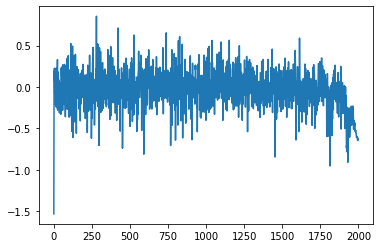

In [29]:
Ene_v_sum_list = []
Ene_v_sum_list_append = Ene_v_sum_list.append
for each_Ene in Ene:
    Ene_v_sum = 0
    for Ene_v in each_Ene.values():
        Ene_v_sum += Ene_v
    Ene_v_sum_list_append(Ene_v_sum/K)
#Ene_v_sum_list
plt.plot(Ene_v_sum_list)
plt.savefig('meeting_0421_figure.png')
print(Ene_v_sum_list[-1])

In [30]:
y_list_df = pd.DataFrame(y_list)  #i(温度)ごとに、選択したyを記録していく。(行i, 要素num_tl)

y_list_df

,0,1,2,3,4,5,6,7,8,9,...,410,411,412,413,414,415,416,417,418,419
0,TCGA-A8-A092-01 0 TCGA-D8-A1JK-01 0 TCGA...,TCGA-A8-A092-01 0 TCGA-D8-A1JK-01 0 TCGA...,TCGA-A8-A092-01 0 TCGA-D8-A1JK-01 0 TCGA...,TCGA-A8-A092-01 0 TCGA-D8-A1JK-01 0 TCGA...,TCGA-A8-A092-01 0 TCGA-D8-A1JK-01 0 TCGA...,TCGA-A8-A092-01 0 TCGA-D8-A1JK-01 0 TCGA...,TCGA-A8-A092-01 0 TCGA-D8-A1JK-01 0 TCGA...,TCGA-A8-A092-01 0 TCGA-D8-A1JK-01 0 TCGA...,TCGA-A8-A092-01 0 TCGA-D8-A1JK-01 0 TCGA...,TCGA-A8-A092-01 0 TCGA-D8-A1JK-01 0 TCGA...,...,TCGA-A8-A092-01 0 TCGA-D8-A1JK-01 0 TCGA...,TCGA-A8-A092-01 0 TCGA-D8-A1JK-01 0 TCGA...,TCGA-A8-A092-01 0 TCGA-D8-A1JK-01 0 TCGA...,TCGA-A8-A092-01 0 TCGA-D8-A1JK-01 0 TCGA...,TCGA-A8-A092-01 0 TCGA-D8-A1JK-01 0 TCGA...,TCGA-A8-A092-01 0 TCGA-D8-A1JK-01 0 TCGA...,TCGA-A8-A092-01 0 TCGA-D8-A1JK-01 0 TCGA...,TCGA-A8-A092-01 0 TCGA-D8-A1JK-01 0 TCGA...,TCGA-A8-A092-01 0 TCGA-D8-A1JK-01 0 TCGA...,TCGA-A8-A092-01 0 TCGA-D8-A1JK-01 0 TCGA...
1,TCGA-A8-A092-01 0 TCGA-D8-A1JK-01 0 TCGA...,TCGA-A8-A092-01 0 TCGA-D8-A1JK-01 0 TCGA...,TCGA-A8-A092-01 0 TCGA-D8-A1JK-01 0 TCGA...,TCGA-A8-A092-01 0 TCGA-D8-A1JK-01 0 TCGA...,TCGA-A8-A092-01 0 TCGA-D8-A1JK-01 0 TCGA...,TCGA-A8-A092-01 0 TCGA-D8-A1JK-01 0 TCGA...,TCGA-A8-A092-01 0 TCGA-D8-A1JK-01 0 TCGA...,TCGA-A8-A092-01 0 TCGA-D8-A1JK-01 0 TCGA...,TCGA-A8-A092-01 0 TCGA-D8-A1JK-01 0 TCGA...,TCGA-A8-A092-01 0 TCGA-D8-A1JK-01 0 TCGA...,...,TCGA-A8-A092-01 0 TCGA-D8-A1JK-01 0 TCGA...,TCGA-A8-A092-01 0 TCGA-D8-A1JK-01 0 TCGA...,TCGA-A8-A092-01 0 TCGA-D8-A1JK-01 0 TCGA...,TCGA-A8-A092-01 0 TCGA-D8-A1JK-01 0 TCGA...,TCGA-A8-A092-01 0 TCGA-D8-A1JK-01 0 TCGA...,TCGA-A8-A092-01 0 TCGA-D8-A1JK-01 0 TCGA...,TCGA-A8-A092-01 0 TCGA-D8-A1JK-01 0 TCGA...,TCGA-A8-A092-01 0 TCGA-D8-A1JK-01 0 TCGA...,TCGA-A8-A092-01 0 TCGA-D8-A1JK-01 0 TCGA...,TCGA-A8-A092-01 0 TCGA-D8-A1JK-01 0 TCGA...
2,TCGA-A8-A092-01 0 TCGA-D8-A1JK-01 0 TCGA...,TCGA-A8-A092-01 0 TCGA-D8-A1JK-01 0 TCGA...,TCGA-A8-A092-01 0 TCGA-D8-A1JK-01 0 TCGA...,TCGA-A8-A092-01 0 TCGA-D8-A1JK-01 0 TCGA...,TCGA-A8-A092-01 0 TCGA-D8-A1JK-01 0 TCGA...,TCGA-A8-A092-01 0 TCGA-D8-A1JK-01 0 TCGA...,TCGA-A8-A092-01 0 TCGA-D8-A1JK-01 0 TCGA...,TCGA-A8-A092-01 0 TCGA-D8-A1JK-01 0 TCGA...,TCGA-A8-A092-01 0 TCGA-D8-A1JK-01 0 TCGA...,TCGA-A8-A092-01 0 TCGA-D8-A1JK-01 0 TCGA...,...,TCGA-A8-A092-01 0 TCGA-D8-A1JK-01 0 TCGA...,TCGA-A8-A092-01 0 TCGA-D8-A1JK-01 0 TCGA...,TCGA-A8-A092-01 0 TCGA-D8-A1JK-01 0 TCGA...,TCGA-A8-A092-01 0 TCGA-D8-A1JK-01 0 TCGA...,TCGA-A8-A092-01 0 TCGA-D8-A1JK-01 0 TCGA...,TCGA-A8-A092-01 0 TCGA-D8-A1JK-01 0 TCGA...,TCGA-A8-A092-01 0 TCGA-D8-A1JK-01 0 TCGA...,TCGA-A8-A092-01 0 TCGA-D8-A1JK-01 0 TCGA...,TCGA-A8-A092-01 0 TCGA-D8-A1JK-01 0 TCGA...,TCGA-A8-A092-01 0 TCGA-D8-A1JK-01 0 TCGA...
3,TCGA-A8-A092-01 0 TCGA-D8-A1JK-01 0 TCGA...,TCGA-A8-A092-01 0 TCGA-D8-A1JK-01 0 TCGA...,TCGA-A8-A092-01 0 TCGA-D8-A1JK-01 0 TCGA...,TCGA-A8-A092-01 0 TCGA-D8-A1JK-01 0 TCGA...,TCGA-A8-A092-01 0 TCGA-D8-A1JK-01 0 TCGA...,TCGA-A8-A092-01 0 TCGA-D8-A1JK-01 0 TCGA...,TCGA-A8-A092-01 0 TCGA-D8-A1JK-01 0 TCGA...,TCGA-A8-A092-01 0 TCGA-D8-A1JK-01 0 TCGA...,TCGA-A8-A092-01 0 TCGA-D8-A1JK-01 0 TCGA...,TCGA-A8-A092-01 0 TCGA-D8-A1JK-01 0 TCGA...,...,TCGA-A8-A092-01 0 TCGA-D8-A1JK-01 0 TCGA...,TCGA-A8-A092-01 0 TCGA-D8-A1JK-01 0 TCGA...,TCGA-A8-A092-01 0 TCGA-D8-A1JK-01 0 TCGA...,TCGA-A8-A092-01 0 TCGA-D8-A1JK-01 0 TCGA...,TCGA-A8-A092-01 0 TCGA-D8-A1JK-01 0 TCGA...,TCGA-A8-A092-01 0 TCGA-D8-A1JK-01 0 TCGA...,TCGA-A8-A092-01 0 TCGA-D8-A1JK-01 0 TCGA...,TCGA-A8-A092-01 0 TCGA-D8-A1JK-01 0 TCGA...,TCGA-A8-A092-01 0 TCGA-D8-A1JK-01 0 TCGA...,TCGA-A8-A092-01 0 TCGA-D8-A1JK-01 0 TCGA...
4,TCGA-A8-A092-01 0 TCGA-D8-A1JK-01 0 TCGA...,TCGA-A8-A092-01 0 TCGA-D8-A1JK-01 0 TCGA...,TCGA-A8-A092-01 0 TCGA-D8-A1JK-01 0 TCGA...,TCGA-A8-A092-01 0 TCGA-D8-A1JK-01 0 TCGA...,TCGA-A8-A092-01 0 TCGA-D8-A1JK-01 0 TCGA...,TCGA-A8-A092-01 0 TCGA-D8-A1JK-01 0 TCGA...,TCGA-A8-A092-01 0 TCGA-D8-A1JK-01 0 TCGA...,TCGA-A8-A092-01 0 TCGA-D8-A1JK-01 0 TCGA...,TCGA-A8-A092-01 0 TCGA-D8-A1JK-01 0 T